In [109]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
import seaborn as sns
import warnings

import nibabel as nib
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [110]:
# In this cell, we plot one slice of the MRI of a subject

# We first load the 2 files associated to raw data and segmentation
import os
from IPython.display import clear_output

#Collect all pre-processed images from .anat directories
skullstripped_img_list = []
ori_img_list = []
seg_img_list = []
file_id = []
sample_size = 0
root_path = "/shared/ixi-dataset/"
for i in range(19):
    dir_name = root_path + "IXI-T1-" + str(i)
    anat_directories = [x for x in os.listdir(dir_name) if x.endswith('.anat')]
    for anat_directory in anat_directories:
        ori_file_name = dir_name + '/' + anat_directory + '/T1_biascorr.nii.gz'
        seg_file_name = dir_name + '/' + anat_directory + "/T1_fast_seg.nii.gz"
        if anat_directory[0:3] == 'IXI' and os.path.exists(ori_file_name) and os.path.exists(seg_file_name):
            ori_img = nib.load(ori_file_name).get_data()
            seg_img = nib.load(seg_file_name).get_data()
            skullstripped_img = ori_img * (seg_img > 0)
            ori_img_list.append(ori_img)
            seg_img_list.append(seg_img)
            skullstripped_img = (skullstripped_img - np.mean(skullstripped_img)) / np.std(skullstripped_img)
            skullstripped_img_list.append(skullstripped_img)
            file_id.append(anat_directory[3:6])
            sample_size += 1
            clear_output(wait=True)
            #print(sample_size)
print(len(file_id))
print(len(skullstripped_img_list))

536
536


In [111]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [113]:
# Download and load the pretrained SqueezeNet model.
# model = torchvision.models.resnet50(pretrained=True)
model = torch.load('/model/the_whole_model.pth')
# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

In [114]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [115]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[ 0.4937, -0.8435, -0.2546,  1.7318, -0.6319],
        [ 0.2608, -2.1850, -1.5432,  1.1418, -0.9035],
        [-0.6528, -0.7473, -2.5200,  0.1544, -1.2003],
        [ 0.0174, -0.7109,  1.5958, -0.4934,  0.9303]])
tensor([1, 2, 1, 3])
tensor([-0.8435, -1.5432, -0.7473, -0.4934])


In [147]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    scores = model(X)
    loss = torch.sum(scores)
    loss.backward()
    grads = X.grad
    saliency,_ = torch.max(grads.abs(),1)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [148]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.from_numpy(X)
    X_tensor = X_tensor.to(device,dtype=dtype)
    y = y.to(device,dtype=dtype)
#     y_tensor = torch.from_numpy(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y, model)
    
    s = int(X.shape[2] / 2)
    dimension = 2
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N = X.shape[0]
    print(N)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].transpose((1,2,0)))
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.show()



In [149]:
new_img_list = []

for i in range(len(skullstripped_img_list)):    
    new_img = skullstripped_img_list[i][16:240,90,:]
    #modify the dimensions by cropping and zero-padding so that all the images' sizes become 224*224
    d_2 = new_img.shape[1]
    if d_2 % 2 == 0:
        pad_width = int((224 - d_2) / 2)
        new_img = np.pad(np.asarray(new_img),((0,0),(pad_width, pad_width)),"constant") 
    else: 
        pad_width_0 = int((224 - d_2) / 2)
        pad_width_1 = pad_width_0 + 1
        new_img = np.pad(np.asarray(new_img),((0,0),(pad_width_0, pad_width_1)),"constant") 
    final_img = np.tile(new_img,(3,1)).reshape((3,224,224))
    new_img_list.append(final_img)    
new_img_list = np.asarray(new_img_list)
print('Shape of the MRI : {}'.format(new_img_list.shape))



Shape of the MRI : (536, 3, 224, 224)


In [150]:
print(new_img_list.shape)

(536, 3, 224, 224)


In [151]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 3, 224, 224)
1


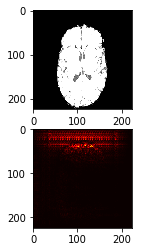

In [152]:
X = torch.load("/data/data.pt")
y = torch.load("/data/ages.pt")
print(new_img_list[0:2].shape)
show_saliency_maps(new_img_list[105:106], y[105:106])